In [102]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [103]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from typing import TypedDict, Literal, Annotated

In [104]:
groq_api_key = os.getenv("GROQ_API_KEY")

In [105]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")

In [107]:
generator_llm = evaluator_llm = optimizer_llm = llm

In [108]:
from pydantic import BaseModel, Field

In [109]:
class PostEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="Feedback for the post.")

In [110]:
structured_evaluator_llm = evaluator_llm.with_structured_output(PostEvaluation)

### State

In [111]:
class PostState(TypedDict):
    topic: str
    post: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int
    post_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [112]:
def generate_post(state: PostState):
    messages = [
        SystemMessage(content="You are a very funny & clever Instagram influencer."),
        HumanMessage(content=f"""
        Write a short, original and hilarious post on the topic: "{state["topic"]}".
        Rules:
            - Do NOT use question-answer format.
            - Max 280 characters.
            - Use observational humor, irony, sarcasm, or cultural references.
            - Think in meme logic, punchlines, or relatable takes.
            - Use simple, day to day english
        """)
    ]
    response = generator_llm.invoke(messages).content
    return {"post": response, "post_history":[response]}

In [113]:
def evaluate_post(state: PostState):
    messages = [
        SystemMessage(content="You are a ruthless, no laugh given Insta critic. You evaluate " \
        "posts based on the humour, originality, virality and post format."),
        HumanMessage(content=f"""
        Evaluate the following post:
        Post: "{state['post']}"
        Use the criteria below to evaluate the post:
        1. Originality – Is this fresh, or have you seen it a hundred times before?  
        2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
        3. Punchiness – Is it short, sharp, and scroll-stopping?  
        4. Virality Potential – Would people repost or share it?  
        5. Format – Is it a well-formed post (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

        Auto-reject if:
        - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
        - It exceeds 280 characters
        - It reads like a traditional setup-punchline joke
        - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

        ### Respond ONLY in structured format:
        - evaluation: "approved" or "needs_improvement"  
        - feedback: One paragraph explaining the strengths and weaknesses 
        """)
    ]
    response = structured_evaluator_llm.invoke(messages)
    return {"evaluation": response.evaluation, "feedback": response.feedback, "feedback_history":[response.feedback]}

In [114]:
def optimize_post(state: PostState):
    messages = [
        SystemMessage(content="You punch up posts for virality and humor based on given feedback."),
        HumanMessage(content=f"""
        Improve the post based on this feedback:
        "{state["feedback"]}"

        Topic: "{state["topic"]}"
        Original Post: "{state["post"]}"
        Re-write it as a short, viral-worthy post. Avoid Q&A style and stay under 280 characters.
        """)
    ]
    response = optimizer_llm.invoke(messages).content
    iteration = state["iteration"]+1
    return {"post": response, "iteration": iteration, "post_history":[response]}


In [115]:
def route_evaluation(state: PostState):
    if state["evaluation"] == "approved" or state["iteration"] >= state["max_iteration"]:
        return "approved"
    else:
        return "needs_improvement"

In [116]:
graph_builder = StateGraph(PostState)

In [117]:
graph_builder

In [118]:
graph_builder.add_node("generator", generate_post)
graph_builder.add_node("evaluator", evaluate_post)
graph_builder.add_node("optimizer", optimize_post)

graph_builder.add_edge(START, "generator")
graph_builder.add_edge("generator", "evaluator")

graph_builder.add_conditional_edges("evaluator", route_evaluation, {"approved": END, "needs_improvement": "optimizer"})
graph_builder.add_edge("optimizer", "evaluator")

In [119]:
graph = graph_builder.compile()

In [120]:
graph

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<topic,post,evaluation,feedback,iteration,max_iteration,post_history,feedback_history>(recurse=True, writes=[ChannelWriteEntry(channel='topic', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='post', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='evaluation', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='feedback', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='iteration', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='max_iteration',

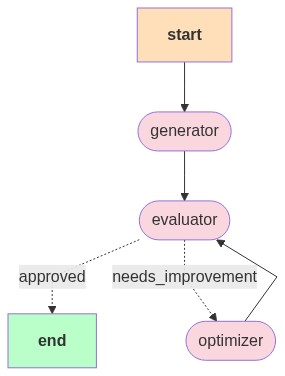

In [121]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [122]:
initial_state = {
    "topic": "Insta",
    "iteration": 1,
    "max_iteration": 5
}

In [124]:
graph

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<topic,post,evaluation,feedback,iteration,max_iteration,post_history,feedback_history,start:generator>(recurse=True, writes=[ChannelWriteEntry(channel='topic', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='post', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='evaluation', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='feedback', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='iteration', value=<object object at 0x000001884B4EEC70>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel=

In [125]:
result = graph.stream(initial_state)
result

<generator object Pregel.stream at 0x000001885D556BD0>